# Notebook to generate psychometrics plot given sessions & conditions

In [1]:
import datajoint as dj
import numpy as np
import pylab as plt
import matplotlib.patches as mpatches
import pandas as pd
from scipy.optimize import curve_fit
from astropy.stats import binom_conf_interval
import datetime

### Datajoint configuration

In [2]:
dj.config['database.host'] = 'datajoint00.pni.princeton.edu'
dj.config['enable_python_native_blobs'] = True

dj.config['stores'] = {
    'extstorage':
    {
        'location': '/Volumes/u19_dj/external_dj_blobs',
        'protocol': 'file'
    }
}

### Connection to DB

In [3]:
dj.conn()

Please enter DataJoint username: alvaros
Please enter DataJoint password: ········
Connecting alvaros@datajoint00.pni.princeton.edu:3306


DataJoint connection (connected) alvaros@datajoint00.pni.princeton.edu:3306

In [4]:
behavior = dj.create_virtual_module('behavior', 'u19_behavior')
optogenetics = dj.create_virtual_module('optogenetics', 'u19_optogenetics')
acquisition = dj.create_virtual_module('subject', 'u19_acquisition')

## General parameters 

In [ ]:
#List of colors
colors = ['k', 'b']

#List of conditions to filter sessions, trials, etc for analysis
key_selection  = ['subject_fullname like "efonseca_Vgat%"', 'level = 14', 'is_bad_session = 0']

#List of tables to "prefilter data" (generally session or block tables)
table_prefilters = [behavior.TowersBlock]

#List of conditions to compare (data will be filtered for all conditions and saved plotted)
condition_key    = ['stim_on = 0', 'stim_on = 1']
#Labels for legend (if empty will be the smae as condition_key)
condition_labels = ['Laser On', 'Laser Off']


### Sigmoid function definition

In [5]:
def psychometrics_function(x, O, A, lambd, x0):
    return O + A/(1+np.exp(-(x-x0)/lambd))

### Function to fit eveidence & choices to the sigmoid function (from SueAnn's original Matlab function)

In [6]:
def psychFit(deltaBins, numR, numL, choices):

    numRight            = np.zeros(len(deltaBins))
    numTrials           = np.zeros(len(deltaBins))
    trialDelta          = np.zeros(len(deltaBins))
    phat                = np.zeros(len(deltaBins))
    pci                 = np.zeros((2, len(deltaBins)))
    
    #Evidence variable
    nCues_RminusL       = numR - numL
    #Correct deltaBin & trialBin to produce same result as Matlab psychFit
    deltaBins_search =  deltaBins.astype(float) - 1.5
    trialBin = np.searchsorted(deltaBins_search, nCues_RminusL, side='right')
    trialBin -= 1;
    
    #Put into evidence bins all Trials with corresponding choices
    for iTrial in range(len(choices)):
        numTrials[trialBin[iTrial]]   = numTrials[trialBin[iTrial]] + 1
        if choices[iTrial] == 2:
            numRight[trialBin[iTrial]]  = numRight[trialBin[iTrial]] + 1
            
        trialDelta[trialBin[iTrial]]  = trialDelta[trialBin[iTrial]] + nCues_RminusL[iTrial]
      
    with np.errstate(divide='ignore', invalid='ignore'):
        trialDelta          = np.true_divide(trialDelta, numTrials);
    
    # Select only bins with trials
    idx_zero = numTrials == 0    
    numTrials_nz = numTrials[~idx_zero]
    numRight_nz  = numRight[~idx_zero]
        
    #(Binomial proportion confidence interval given k successes, n trials)
    phat_nz = binom_conf_interval(numRight_nz, numTrials_nz, confidence_level=0, interval='jeffreys')
    pci_nz  = binom_conf_interval(numRight_nz, numTrials_nz, confidence_level=1-0.1587, interval='jeffreys')
    
    #Correct confidence intervals and expected outcomes for bins with no trials (ci = [0 1], hat = 0.5)
    phat_nz = phat_nz[0]
    phat[~idx_zero] = phat_nz
    phat[idx_zero]  = 0.5
    pci[0][~idx_zero] = pci_nz[0]
    pci[0][idx_zero]  = 0
    pci[1][~idx_zero] = pci_nz[1]
    pci[1][idx_zero]  = 1
    
    # (Logistic function fit) only valid if we have at least 5 bins with trials
    if np.count_nonzero(~idx_zero) < 5:
        is_there_psychometric = False
    else:
        is_there_psychometric = True
        #Get weight matrix to "reproduce" Matlab fit 
        #https://stackoverflow.com/questions/58983113/scipy-curve-fit-vs-matlab-fit-weighted-nonlinear-least-squares
        # matlab -> 'Weights'         , ((pci(sel,2) - pci(sel,1))/2).^-2 
        # python -> sigma = diagonal_matrix(1/weights)
        
        weight_array = np.power((pci[1][~idx_zero] - pci[0][~idx_zero])/2,2)
        sigma_fit    = np.diag(weight_array)
        
        psychometric, pcov = curve_fit(psychometrics_function, deltaBins[~idx_zero], phat[~idx_zero], \
                                          p0 = (0, 1, 3, 0),sigma = sigma_fit, maxfev=40000)

    #Append a row of nans to confidence intervals . whyy ??
    aux_vec = np.empty((1,pci.shape[1]))
    aux_vec[:] = np.nan
    pci = np.vstack((pci, aux_vec))
    
    # x vector for plotting
    delta      = np.linspace(deltaBins[0]-2, deltaBins[-1]+2, num=50)

    # Repeat trialDelta 3 times for errorX why ??
    errorX = np.tile(trialDelta[~idx_zero], 3);
    
    # Confidence intervals are errorY, as a vector
    errorY = np.stack(pci[:,~idx_zero])
    errorY = errorY.flatten()
    
    # Fill  dictionary of results
    fit_results = dict()
    fit_results['delta_bins']   = deltaBins[~idx_zero]
    fit_results['delta_data']   = trialDelta[~idx_zero];
    fit_results['pright_data']  = 100*phat[~idx_zero];
    fit_results['delta_error']  = errorX;
    fit_results['pright_error'] = 100*errorY;
    
    if is_there_psychometric:
        fit_results['delta_fit']  = delta
        fit_results['pright_fit'] = psychometrics_function(delta, *psychometric)*100
    else:
        fit_results['delta_fit']  = np.empty([0])
        fit_results['pright_fit'] = np.empty([0])
    
    return fit_results


### Session selection

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,block block number,task,main_level main level on current block,level difficulty level,set_id parameter set id,n_trials number of trials in this block,first_trial trial_idx of the first trial in this block,"block_duration in secs, duration of the block",block_start_time absolute start time of the block,"reward_mil in mL, reward volume in this block",reward_scale scale of the reward in this block,easy_block true if the difficulty reduces during the session,block_performance performance in the current block
efonseca_Vgat01_586,2020-11-21,0,2,Towers,14,14,1,132,13,1702.01,2020-11-21 13:16:00,0.648,2,0,0.674242
efonseca_Vgat01_586,2020-11-21,0,4,Towers,14,14,1,41,155,657.035,2020-11-21 13:47:00,0.2376,3,0,0.536585
efonseca_Vgat01_586,2020-11-21,0,6,Towers,14,14,1,40,206,599.754,2020-11-21 14:00:00,0.216,3,0,0.5
efonseca_Vgat01_586,2020-11-21,0,8,Towers,14,14,1,5,256,105.657,2020-11-21 14:12:00,0.0108,3,0,0.2
efonseca_Vgat01_586,2020-11-22,0,2,Towers,14,14,1,165,13,2114.6,2020-11-22 13:09:00,0.7848,2,0,0.642424
efonseca_Vgat01_586,2020-11-22,0,4,Towers,14,14,1,40,188,569.141,2020-11-22 13:46:00,0.1764,2,0,0.525
efonseca_Vgat01_586,2020-11-22,0,6,Towers,14,14,1,39,238,525.99,2020-11-22 13:58:00,0.2268,2,0,0.692308
efonseca_Vgat01_586,2020-11-23,0,2,Towers,14,14,1,216,18,2969.81,2020-11-23 12:14:00,1.074,2,0,0.675926
efonseca_Vgat01_586,2020-11-23,0,4,Towers,14,14,1,13,244,218.149,2020-11-23 13:07:00,0.0456,2,0,0.461538
efonseca_Vgat01_586,2020-11-24,0,2,Towers,14,14,1,271,17,3477.76,2020-11-24 13:10:00,1.5168,2,0,0.774908


In [9]:
### Create label and color patches for plot

In [40]:

condition_labels
laser_keys = ['stim_on = 0', 'stim_on = 1']

#Assign a color to each label
zip_iterator = zip(laser_keys, colors)
color_dict = dict(zip_iterator)

#Create a color patch for plot legend
patches_legend = []
for key in color_dict:
    patches_legend.append(mpatches.Patch(color=color_dict[key], label=key))

color_dict

{'stim_on = 0': 'k', 'stim_on = 1': 'b'}

### Select bins for evidence data (automate this step ??)

In [16]:
deltaBins = np.arange(-15, 16, step=3)
deltaBins

array([-15, -12,  -9,  -6,  -3,   0,   3,   6,   9,  12,  15])

### Fit all sessions to sigmoid and plot

,Type,%Correct,Total trials
0,stim_on = 0,0.618312,12298.0
1,stim_on = 1,0.568780,3075.0


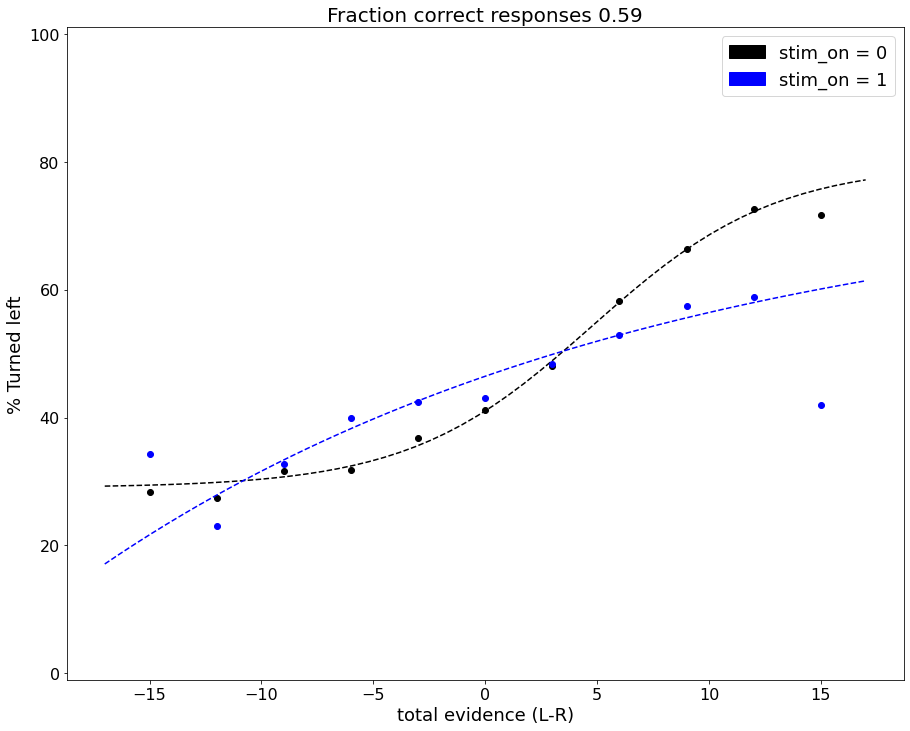

In [45]:

plt.figure(figsize=(15, 12))
fraction_correct = np.zeros(len(laser_keys))
tot_trials       = np.zeros(len(laser_keys))
list_summary = list()
for key_idx, key in enumerate(laser_keys):

    thisCondition = behavior.TowersBlock().Trial() * optogenetics.OptogeneticSession().Trial & keys_table & key
    
    
    
    # Fetch session
    session_info = pd.DataFrame(thisCondition.fetch('choice', 'trial_type', 'cue_presence_left', 'cue_presence_right', 'stim_on', as_dict=True))
    
    
    # Choice and trial type as integer
    session_info['trial_type_int'] = 0
    session_info.loc[session_info['trial_type'] == 'L','trial_type_int'] = 1 
    session_info.loc[session_info['trial_type'] == 'R','trial_type_int'] = 2 
    session_info['choice_int'] = 0
    session_info.loc[session_info['choice'] == 'L','choice_int'] = 1 
    session_info.loc[session_info['choice'] == 'R','choice_int'] = 2
    
    # number of towers per trial
    session_info['cue_presence_left'] = session_info['cue_presence_left'].apply(lambda x: np.count_nonzero(x))
    session_info['cue_presence_right'] = session_info['cue_presence_right'].apply(lambda x: np.count_nonzero(x))
    
    
    fraction_correct[key_idx] = np.sum(session_info['choice'].values == session_info['trial_type'].values)/session_info.shape[0]
    tot_trials[key_idx]       = session_info.shape[0]
    
    dict_summary = dict()
    dict_summary['Type']         =  key
    dict_summary['%Correct']     =  fraction_correct[key_idx]
    dict_summary['Total trials'] =  tot_trials[key_idx]
    
    list_summary.append(dict_summary)
    
    # Call Fit to sigmoid function
    fit_dict = psychFit(deltaBins, session_info['cue_presence_right'].values, \
                        session_info['cue_presence_left'].values, session_info['choice_int'].values)
   
    #Select color from color dictionary
    color_plot = color_dict[key]
    #Plot results
    plt.plot(fit_dict['delta_bins'], fit_dict['pright_data'], 'o', color = color_plot)
    if fit_dict['delta_fit'].shape[0] > 0:
        plt.plot(fit_dict['delta_fit'], fit_dict['pright_fit'], '--', color = color_plot)
        
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("total evidence (L-R)", fontsize=18)
plt.ylabel("% Turned left", fontsize=18)
plt.ylim([-1, 101])
#pl.xlim([-11,11])
mean_correct_string = f"{np.mean(fraction_correct):2.2f}"
plt.title('Fraction correct responses '+mean_correct_string, fontsize=20)
plt.legend(handles=patches_legend, fontsize=18)

df_summary = pd.DataFrame(list_summary)


df_summary